# **Speech Emotion Recognition (Classification) in real-time using Deep LSTM layers**
### ***Data preprocess representation for a single audio file***
---

### Final project (B.Sc. requirement)  
Development by **Meidan Greenberg & Linoy Hadad.**

Instructor: **Dr. Dima Alberg**

Industial Engineering and Management dept.

SCE Collage, Israel.





# **LIBRARIES & GOOGLE AUTH**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
%%capture
!pip install pydub
!pip install noisereduce

In [ ]:
%%capture
import os
import numpy as np

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import matplotlib.pyplot as plt
from librosa import display
import IPython.display as ipd

# **DATA PREPROCESS REPRESENTATION**
This notebook present the data preprocessing for a single audio file.
The preprocess is described in the following diagram:
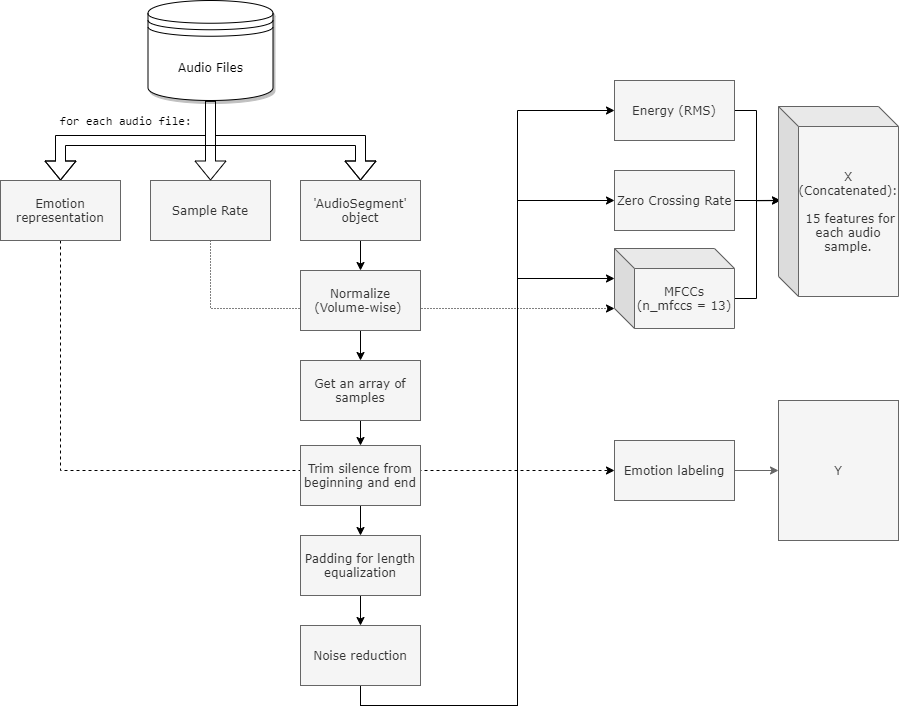

## **Diagram Explanation**
In general, The following data is extracted from each audio file:
1.   **Emotion representation**

    *   RAVDESS: The filename contains a number that represents an emotion, e.g. 03 is happy.
    *   TESS: The filename contains a direct representation of an emotion, e.g 'happy'.


2.   **Sample Rate**: number of audio samples per second. RAVDESS database was recorded in 48kHz, and the TESS database was recorded in 22.5kHz.

3. **The audio** is processed in the following order:


*   'AudioSegment' instance: The audio is loaded to an object by the library 'AudioSegment'.
*   Normalization: Each 'AudioSegment' object is normalized to + 5.0 dBFS.

*   Transforming the object to an array of samples is crucial for the rest of the preprocessing.
*   Trimming the silence in the beginning and the end, to get rid of unnecessary data.
*   Padding every audio file to the same length, for length equalization.
*   Noise reduction is being performed.
---


## **Audio preprocess for a single file**

In [ ]:
# Define file path for a single file.
path = '/content/Angry mood.wav.wav'

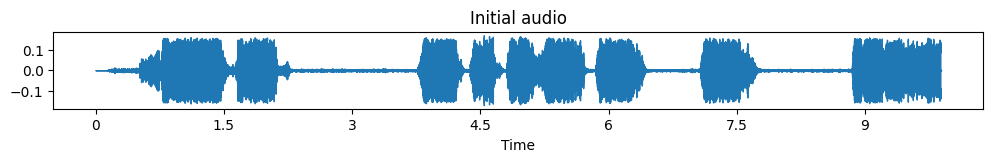

In [ ]:
# 1. Load the audio file into an 'AudioSegment' object, and extract the sample rate.
#    'x' is an array of samples that is only relevant for visualization at this part.

rawsound = AudioSegment.from_file(path)
x, sr = librosa.load(path, sr = None)

plt.figure(figsize=(12,1))
librosa.display.waveshow(x, sr=sr)
plt.title('Initial audio')

rawsound

The actual audio as well as the 'y' axis range suggests that the initial audio is very low-volumed. This can interfere with the feature extraction validity.




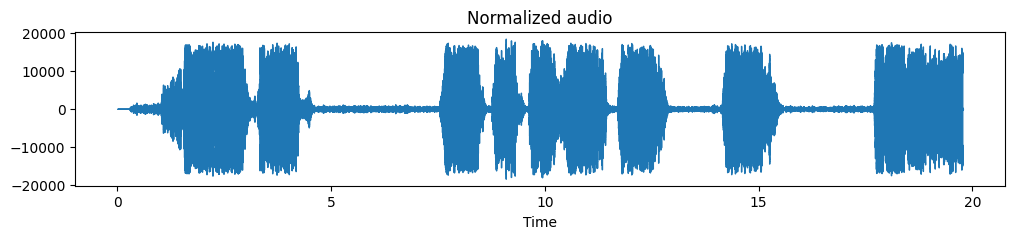

In [ ]:
# 2. Normalize to +5.0 dBFS, Transform audio signals to an array.

normalizedsound = effects.normalize(rawsound, headroom = 5.0)
normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')

plt.figure(figsize=(12,2))
librosa.display.waveshow(normal_x, sr=sr)
plt.title('Normalized audio')

normalizedsound

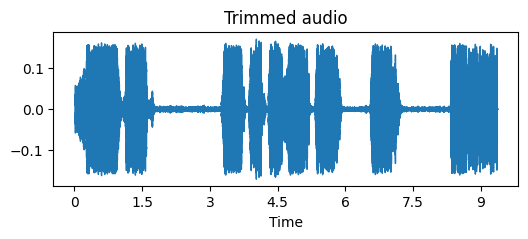

In [ ]:
# 3. Trim silence in the beginning and end with correct sample rate

import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import IPython.display as ipd

# Load audio with the original sample rate
file_path = "/content/Angry mood.wav.wav"  # Replace with the correct path

# Retrieve the original sample rate to prevent stretching
with sf.SoundFile(file_path) as f:
    sr_original = f.samplerate

# Load with the correct sample rate
normal_x, sr = librosa.load(file_path, sr=sr_original)

# Trim silence
xt, index = librosa.effects.trim(normal_x, top_db=15)

# Plot the trimmed audio
plt.figure(figsize=(6, 2))
librosa.display.waveshow(xt, sr=sr)
plt.title('Trimmed audio')

# Display the trimmed audio at the correct speed
ipd.display(ipd.Audio(data=xt, rate=sr))


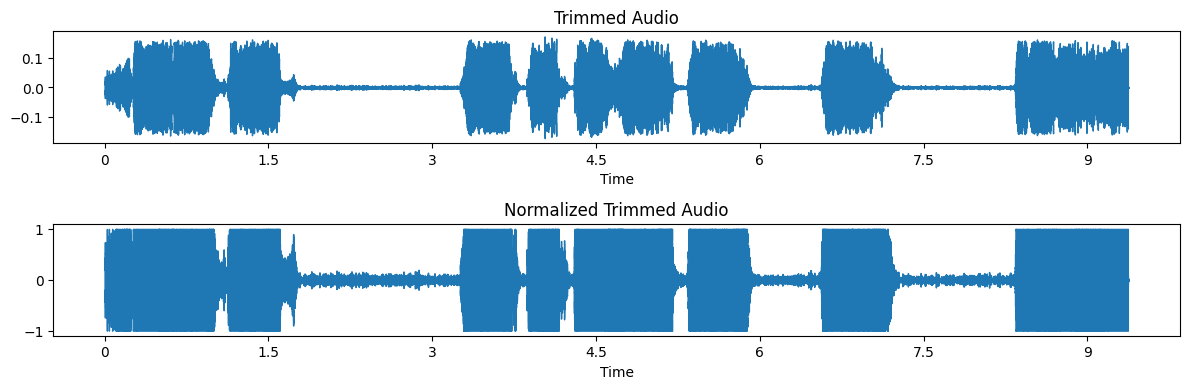

In [ ]:
# 3. Trim silence in the beginning and end, then normalize to +5.0 dBFS

import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

# Load audio with the original sample rate
file_path = "/content/Angry mood.wav.wav"  # Replace with the correct path

# Retrieve the original sample rate
with sf.SoundFile(file_path) as f:
    sr_original = f.samplerate

# Load the audio at the correct sample rate
y, sr = librosa.load(file_path, sr=sr_original)

# Step 1: Trim silence
xt, index = librosa.effects.trim(y, top_db=20)

# Step 2: Normalize the trimmed audio to +5.0 dBFS
def normalize_audio(audio, target_dbfs=-1.0):
    rms = np.sqrt(np.mean(audio**2))
    rms_db = 20 * np.log10(rms)

    # Calculate the gain required to reach target dBFS
    gain_db = target_dbfs - rms_db
    gain = 10**(gain_db / 20)

    # Apply gain
    normalized_audio = audio * gain

    # Clip to prevent distortion
    normalized_audio = np.clip(normalized_audio, -1.0, 1.0)
    return normalized_audio

# Normalize the trimmed audio
normalized_x = normalize_audio(xt)

# Step 3: Apply a low-pass filter to smoothen the audio
def low_pass_filter(audio, cutoff=8000, sr=sr_original, order=4):
    nyquist = 0.5 * sr
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_audio = lfilter(b, a, audio)
    return filtered_audio

# Apply smoothing filter
smoothed_x = low_pass_filter(normalized_x, cutoff=8000)

# Plot the trimmed and normalized audio
plt.figure(figsize=(12, 4))

# Display the original trimmed waveform
plt.subplot(2, 1, 1)
librosa.display.waveshow(xt, sr=sr_original)
plt.title('Trimmed Audio')

# Display the normalized waveform
plt.subplot(2, 1, 2)
librosa.display.waveshow(normalized_x, sr=sr_original)
plt.title('Normalized Trimmed Audio')

plt.tight_layout()
plt.show()

# Play the final normalized audio at the correct speed
ipd.display(ipd.Audio(data=normalized_x, rate=sr_original))


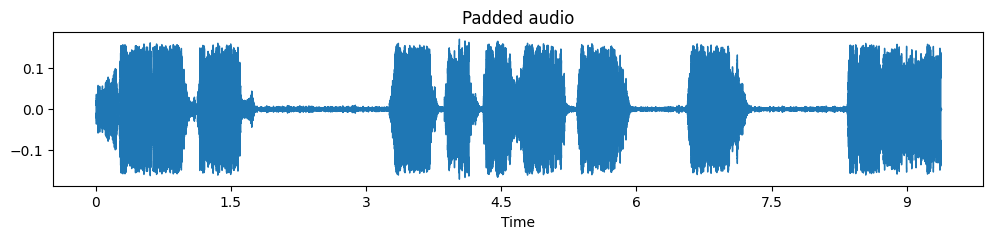

In [ ]:
# 4. Right-side padding for length equalization

# Define the maximum length
max_length = 173056

# Ensure non-negative padding value
padding_length = max(0, max_length - len(xt))

# Apply right-side padding
padded_x = np.pad(xt, (0, padding_length), mode='constant')

# Plot the padded audio
plt.figure(figsize=(12, 2))
librosa.display.waveshow(padded_x, sr=sr)
plt.title('Padded audio')

# Play the padded audio
ipd.display(ipd.Audio(data=padded_x, rate=sr))


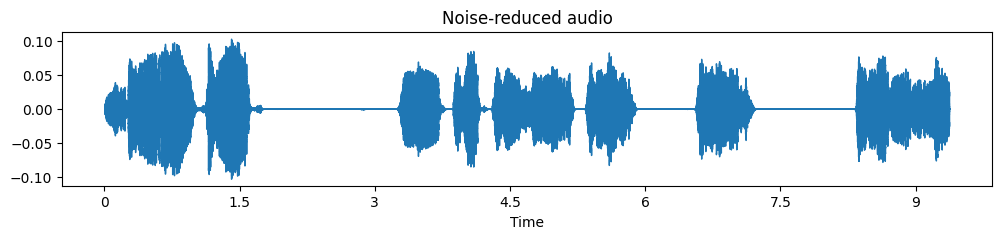

In [ ]:
import noisereduce as nr
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd

# Create a noise profile by selecting a small portion of silence (for cleaner reduction)
noise_profile = padded_x[:5000]  # Extract the first 5000 samples as the noise profile

# stationary noise profile
noise_reduced_audio = nr.reduce_noise(y=padded_x, sr=sr, prop_decrease=1.0)

# Apply noise reduction with the correct parameters
#final_x = nr.reduce_noise(y=padded_x, sr=sr,  # Explicitly include 'sr' with the sample rate
#                          noise=noise_profile)  # Use 'noise' instead of 'noise_clip'


# Plot the noise-reduced audio
plt.figure(figsize=(12, 2))
librosa.display.waveshow(noise_reduced_audio, sr=sr) # final_x changed to noise_reduced_audio
plt.title('Noise-reduced audio')

# Play the final noise-reduced audio
ipd.display(ipd.Audio(data=noise_reduced_audio, rate=sr)) # final_x changed to noise_reduced_audio

## **Features extraction for a single file**
The selected features being extracted with *librosa* for the speech emotion recognition model are:

1.   Energy - Root Mean Square (RMS)
2.   Zero Crossed Rate (ZCR)
3.   Mel-Frequency Cepstral Coefficients (MFCCs)

With frame_length = 2048, hop_lentgh = 512.

Explanation:

Every 2048 samples (sequence of ~0.058 seconds on average) are being analyzed and translated to 4 sequential feature values (2048 / 512 = 4).

In total, for an audio file lengthed 173056 samples, considering the last sample, 339 sequential values are returned for each feature  (173056+1 / 512 = 339).

In [ ]:
# Feature extraction with corrected syntax

import librosa
import numpy as np

# Parameters
frame_length = 2048
hop_length = 512

# Ensure the audio is mono
if len(noise_reduced_audio.shape) > 1:
    noise_reduced_audio = librosa.to_mono(noise_reduced_audio)

# Feature Extraction with corrected syntax
f1 = librosa.feature.rms(y=noise_reduced_audio, frame_length=frame_length, hop_length=hop_length)  # RMS Energy
print('RMS Energy shape:', f1.shape)

f2 = librosa.feature.zero_crossing_rate(y=noise_reduced_audio, frame_length=frame_length, hop_length=hop_length)  # ZCR
print('ZCR shape:', f2.shape)

f3 = librosa.feature.mfcc(y=noise_reduced_audio, sr=sr, S=None, n_mfcc=13, hop_length=hop_length)  # MFCCs
print('MFCCs shape:', f3.shape)


RMS Energy shape: (1, 809)
ZCR shape: (1, 809)
MFCCs shape: (13, 809)


# **CONCLUSIONS**

This notebook presents a **partial** preprocess for one audio file.
The audio preprocess has been executed as well as the extraction of the sample rate, and feature extraction has been shown as well. The full preprocess is executed in "2_model" notebook.

All features have 339 time-steps, thus, all of the data is equally lengthed, as well as homogeneous.